In [1]:
import sys
import math
import datetime as dt
import itertools
import numpy as np
import pandas as pd
from datetime import date
from dateutil.relativedelta import relativedelta
import random

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import seaborn as sns
import matplotlib.pyplot as plt
# from seaborn_qqplot import pplot
# from ismember import ismember

from scipy.linalg import cholesky
from scipy.stats import pearsonr

# import nltk
# from nltk.sentiment import SentimentIntensityAnalyzer
#
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LogisticRegression
# from ismember import ismember

from sklearn.model_selection import train_test_split
# from sklearn.model_selection import GroupShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import confusion_matrix
# from sklearn.compose import ColumnTransformer
# from sklearn.metrics import average_precision_score
# from sklearn.metrics import PrecisionRecallDisplay
# from sklearn.metrics import precision_recall_curve
# from sklearn.metrics import PrecisionRecallDisplay
# from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, recall_score

pd.set_option('display.max_columns',None)

In [2]:
def real_feature_importance(rfm, xcol, inputs):
    df_fimp = pd.DataFrame()
    m = 0
    for feat, importance in zip(xcol, rfm.feature_importances_):
        df_fimp.loc[m,'feature'] = feat
        df_fimp.loc[m,'importance'] = importance
        m += 1
    df_fimp.to_csv('fimp.csv')
    df_real_fimp = pd.DataFrame() 
    m = 0
    for feat in inputs: 
        jun = df_fimp.feature.str.contains(feat)
        #print(m, sum(jun))
        df_real_fimp.loc[m,'feature'] = feat
        df_real_fimp.loc[m,'importance'] = sum(df_fimp.importance[jun])
        m += 1

    df_real_fimp = df_real_fimp.sort_values(by='importance', ascending=False)
    return df_real_fimp

In [3]:
def model_work_v3(df_2, inputs, target, forbidden_features, test_frac, scale_flag, 
                  PC_flag, regress_flag = 0):
    
    if inputs[0] == target:
        X = df_2.drop(inputs, axis = 1)
    else:
        inputs = set(inputs)
        forbidden_features = set(forbidden_features)
        inputs = inputs.difference(forbidden_features)
        X = df_2[inputs]
    
    y = df_2[target]

    if PC_flag == 'none':
        X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                       test_size = test_frac, 
                                                       random_state =1)
    else: 
        train_id = df_2[PC_flag] == 0
        test_id = df_2[PC_flag] == 1
        X_train = X[train_id]
        X_test = X[test_id]
        y_train = y[train_id]
        y_test = y[test_id]
        
    if scale_flag == 1:
        ss = preprocessing.StandardScaler()
        X_train = ss.fit_transform(X_train)
        X_test = ss.transform(X_test)
        X_all = ss.transform(X)

    Ninputs = len(inputs)
    if Ninputs < 10:
        mdepth = 2
    elif (Ninputs >= 10) & (Ninputs < 20):
        mdepth = 3
    elif (Ninputs >= 20) & (Ninputs < 30):
        mdepth = 4
    else:
        mdepth = 5
        
    if regress_flag == 0:
        rf = RandomForestClassifier(n_estimators = 100, max_depth = mdepth, 
                                    max_features = None, 
                                    random_state = 1)
    else:
        params = {
            'n_estimators': 100,
            'max_features': 0.8,
            'max_depth': 8,
            'random_state' : 10,
            'verbose' : 1
        }

        rf = RandomForestRegressor(**params)
        
    rf.fit(X_train, y_train)
    
    
    y_pred_train = rf.predict(X_train)
    y_pred_test = rf.predict(X_test)
    if regress_flag == 0:
        y_pred_prob = rf.predict_proba(X_train)
        y_pred_prob_train = y_pred_prob[:,1]
        y_pred_prob = rf.predict_proba(X_test)
        y_pred_prob_test = y_pred_prob[:,1]    
    
    y_pred_all = rf.predict(X)
    if regress_flag == 0:
        y_pred_prob = rf.predict_proba(X)
        y_pred_prob_all = y_pred_prob[:,1]    

    if regress_flag == 0: 
        fpr_tr, tpr_tr, thresholds_tr = roc_curve(y_train, y_pred_prob_train)
        rfroc_auc_tr = auc(fpr_tr, tpr_tr)
        aucStr_tr = "{:0.3f}".format(rfroc_auc_tr)
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_test)
        rfroc_auc = auc(fpr, tpr)
        aucStr = "{:0.3f}".format(rfroc_auc)
        plt.rcParams["figure.figsize"] = (12,14)
        plt.subplot(2,2,1)
        plt.plot(fpr, tpr, fpr_tr, tpr_tr, [0, 1], [0, 1], '-.')
        plt.xlabel('False positives', fontsize=14)
        plt.ylabel('True positives', fontsize=14)
        plt.legend(['Test','Train','Random'], loc='best')
        plt.title('ROC curves with AUC = ' + aucStr_tr + ', ' + aucStr, fontsize=16)
        #plt.show()

        rff1_score = f1_score(y_test, y_pred_test)

        rfrecall = recall_score(y_test, y_pred_test)

        tgt_rate = np.mean(y)

        if tgt_rate > 0.5:
            y_train = 1 - y_train
            y_pred_prob_train = 1.0 - y_pred_prob_train
            y_test = 1 - y_test
            y_pred_prob_test = 1.0 - y_pred_prob_test
            tgt_rate = 1 - tgt_rate

        precision_tr, recall_tr, thresholds_tr = precision_recall_curve(y_train, 
                                                                        y_pred_prob_train)
        rfroc_auc_tr = auc(recall_tr, precision_tr)
        aucStr_tr = "{:0.3f}".format(rfroc_auc_tr)
        precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob_test)
        rfroc_auc = auc(recall, precision)
        aucStr = "{:0.3f}".format(rfroc_auc)
        plt.subplot(2,2,2)
        plt.plot(recall, precision, recall_tr, precision_tr, [0, 1],[tgt_rate, tgt_rate],'-.')
        plt.xlabel('Recall', fontsize=14)
        plt.ylabel('Precision', fontsize=14)
        plt.legend(['Test','Train','Random'], loc='best')
        plt.title('Precision-recall curves with AUC = ' + aucStr_tr + ', ' + aucStr, 
                  fontsize=16)
    else: #--regression
        plt.rcParams["figure.figsize"] = (12,14)
        plt.subplot(2,2,1)
        plt.plot(y_train,y_pred_train,'.')
        plt.plot([0, max(y_train)/2],[0, max(y_train)/2],'-.')
        tr_corr, _ = pearsonr(y_train, y_pred_train)
        plt.title('Train with rho = %0.3f' %(tr_corr), fontsize=16)
        plt.xlabel('Actual', fontsize=14)
        plt.ylabel('Predicted', fontsize=14)
        plt.subplot(2,2,2)
        plt.plot(y_test,y_pred_test,'.')
        plt.plot([0, max(y_test)/1.5],[0, max(y_test)/1.5],'-.')
        test_corr, _ = pearsonr(y_test, y_pred_test)
        plt.xlabel('Actual', fontsize=14)
        plt.ylabel('Predicted', fontsize=14)
        plt.title('Test with rho = %0.3f' %(test_corr), fontsize=16)
        y_pred_prob_train = [] 
        y_pred_prob_test = [] 
        y_pred_prob_all = []
        
    plt.subplot(2,1,2)
    feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
    feat_importances.nlargest(20).plot(kind='barh')
    plt.gca().invert_yaxis()
    plt.rc('xtick',labelsize=10)
    plt.rc('ytick',labelsize=14)
    plt.title('Feature importance', fontsize=16)
    plt.show()
    
    df_real_fimp = real_feature_importance(rf, X.columns, inputs)
    
    return rf, y_pred_prob_train, y_pred_prob_test, y_pred_prob_all, df_real_fimp

In [4]:
def nan_handler(df, frac_thr, median_flag):
    """Drop Columns having null fraction greater than frac_thr except the columns in col_list. 
    For the columns's null frac < frac_thr, replace the object type as 'unknown' and numeric by mean.
    
        Parameters
        ----------
        data: DataFrame
            Input Dataset and threshold null fraction for processing.
        Returns
        -------
        data: DataFrame
            Returns processed DataFrame.
        """
    df2 = df
    Ns = df.shape[0]
    df_nan = pd.DataFrame()
    m = 0
    dropped_col = []
    for col_ in df.columns:
        null_frac = df[col_].isnull().sum()/Ns
        print(col_, null_frac)
        if (null_frac >= frac_thr):
            df2 = df2.drop(col_, axis = 1)
            dropped_col.append(col_)
        elif (null_frac > 0) & (null_frac < frac_thr) :
            if df2[col_].dtypes == 'object':  #--categorical
                df2[col_] = df2[col_].fillna('Unknown')
            else:  #--numerical
                new_col = col_ + '_na'
                df2[new_col] = df2[col_].isnull()
                if median_flag == 1: 
                    replace_val = np.median(df2[col_][~df2[col_].isnull()])  
                    #--let's use median 
                else:
                    replace_val = np.mean(df2[col_])
                df2[col_] = df2[col_].fillna(replace_val)
                df_nan.loc[m,'feature'] = col_
                df_nan.loc[m,'replace_value'] = replace_val
                #print('test', mean_val)
                m += 1
    return df2, df_nan, dropped_col

In [5]:
def encode_categorical_cols_with_top_n(df, categorical_cols, n=10):
    # TODO memory options
    data = df.copy()
    categorical_encoding_names = {}
    cat_features_after_encoding = []
    for col in categorical_cols:  
        
        feature = col
        cols_before_encoding = data.columns
        
        series = data[col]
        
        top_n = series.value_counts()[:n]
        
        series[~series.isin(top_n.index)] = "grouped_other"
        data[col] = series
        
        data = pd.get_dummies(data, columns=[col])
        
        cols_after_encoding = data.columns
        
        new_features = list(set(cols_after_encoding).difference(set(cols_before_encoding)))
        categorical_encoding_names[feature] = new_features
        cat_features_after_encoding += new_features
    
    return data, categorical_encoding_names, cat_features_after_encoding

# Run parameters

In [6]:
fdir = '/Users/kilster1/Downloads/python/data/auctane/'
fnames = ['test_merchant_feature_set.csv',
          'test_revenue.csv',
          'test_sellers.csv',
          'test_shipments.csv'
         ]
target = 'survival_flag'
regress_target = 'ltv'
nan_thr = 0.9
median_flag = 1
Nmax_cat = 10
test_frac = 0.66
scale_flag = 0
PC_flag2 = 'none'
date_cols = ['cx_merchant_id','first_shipment_date',
            'last_shipment_date','first_order_import_date',
            'last_order_import_date','first_non_manual_order_import_date',
            'first_shipped_non_manual_date','first_ship_from_created_at',
            'first_non_manual_store_integrated_date',
            'first_carrier_create_date','first_non_manual_store_integrated_date',
            'first_carrier_create_date','second_carrier_created_at'
            ]

In [7]:
df_features = pd.read_csv(fdir + fnames[0], low_memory=False)
df_features.tenure_end = pd.to_datetime(df_features.tenure_end)

df_rev = pd.read_csv(fdir + fnames[1], low_memory=False)
df_sellers = pd.read_csv(fdir + fnames[2], low_memory=False)
df_shipments = pd.read_csv(fdir + fnames[3], low_memory=False)
df_features.head()

,cx_merchant_id,first_shipment_date,last_shipment_date,first_order_import_date,last_order_import_date,first_non_manual_order_import_date,first_shipped_non_manual_date,first_non_manual_store_integrated_date,first_carriercreated,first_carrier_create_date,account_status_current,active_marketplace_list,active_marketplace_count,active_carrier_list,active_carrier_count,marketplace_ever_integrated,first_shipped_order_source_non_manual,marketplace_ever_shipped,first_marketplace,first_shipped_order_source,first_carrier_shipped,first_import_order_source,first_import_order_source_non_manual,first_shipped_from,most_freq_shipped_from,first_ship_from_created_at,ship_from_address_count,has_automation_rules,num_automation_rules,second_order_source_integrated_at,second_carrier_created_at,tenure_end,time_to_ship,time_to_first_order_import,time_to_first_non_manual_order_import,merchant_tenure_day,merchant_tenure_month,merchant_tenure_closed_day,merchant_tenure_closed_month,merchant_tenure_conversion_days,primary_3pl_partner,last_one_twenty_day_volume,merchant_volume_tier,last_one_twenty_count,last_one_twenty_list,is_skilljar_merchant,ttm_revenue_pre_churn,ttm_shipments_pre_churn
0,STN-2444342,NaN,NaN,NaN,NaN,NaN,NaN,NaN,USPS,2021-04-20,Trial Unconverted,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-20 20:49:27.997000,1.0,False,NaN,NaN,NaN,2021-05-21,NaN,NaN,NaN,31.0,1.0,NaN,NaN,NaN,NaN,0,NaN,0,NaN,False,NaN,NaN
1,STN-2450311,2021-05-05 00:00:00.000000,2022-09-26 00:00:00.000000,2021-04-26,2022-09-25,2021-04-26,2021-05-05 00:00:00.000000,2021-04-26 14:13:49.227000,USPS,2021-04-26,Subscriber,Shopify,1,"DHL Express from ShipStation, GlobalPost, UPS,...",4,Shopify,Shopify,"Shopify, ShipStation",Shopify,Shopify,GlobalPost,Shopify,Shopify,98057,98057,2021-04-26 14:22:34.523000,1.0,False,NaN,NaN,2021-04-26,2022-09-29,9.0,0.0,0.0,521.0,17.0,459.0,15.0,62.0,NaN,3756,100-999,1,Shopify,False,NaN,NaN
2,STN-2452261,NaN,NaN,2021-04-29,2021-06-29,2021-04-29,NaN,2021-04-29 09:16:14.543000,USPS,2021-04-28,Unactivated Trial,"3dcart, Amazon, eBay",3,NaN,0,"Amazon, eBay, 3dcart",NaN,NaN,Amazon,NaN,NaN,Shift4Shop,Shift4Shop,NaN,NaN,2021-05-03 07:41:27.320000,1.0,False,NaN,2021-04-29 09:31:17.693000,2021-04-29,2021-06-30,NaN,1.0,1.0,63.0,2.0,NaN,NaN,NaN,NaN,0,NaN,0,NaN,False,NaN,NaN
3,STN-2421692,2021-04-10 00:00:00.000000,2022-08-22 00:00:00.000000,2021-04-03,2022-09-21,2021-04-03,2021-04-10 00:00:00.000000,2021-04-03 17:26:52.930000,USPS,2021-04-03,Subscriber,Shopify,1,USPS,1,Shopify,Shopify,"Shopify, ShipStation",Shopify,Shopify,USPS,Shopify,Shopify,92604,92604,2021-04-03 20:04:08.987000,1.0,False,NaN,NaN,2021-04-03,2022-09-29,7.0,0.0,0.0,544.0,17.0,482.0,15.0,62.0,NaN,1,0-99,1,Shopify,False,NaN,NaN
4,STN-2429680,2021-04-23 00:00:00.000000,2022-09-22 00:00:00.000000,2021-04-20,2022-09-22,2021-04-20,2021-04-23 00:00:00.000000,2021-04-08 13:37:09.187000,Canada Post,2021-04-20,Subscriber,Shopify,1,Canada Post,1,Shopify,Shopify,"Shopify, ShipStation",Shopify,Shopify,Canada Post,Shopify,Shopify,K1K3B8,K1K3B8,2021-04-20 20:01:11.970000,1.0,False,NaN,2021-05-03 15:12:22.240000,2021-04-21,2022-09-29,15.0,12.0,12.0,539.0,17.0,506.0,16.0,33.0,NaN,239,0-99,1,Shopify,False,NaN,NaN


In [8]:
jun = df_features.tenure_end < pd.to_datetime('2022-09-29')
df_features['survival_flag'] = 1
df_features.loc[jun,'survival_flag'] = 0

In [9]:
df_features.groupby('survival_flag',dropna=False).agg({
    'active_marketplace_count': ['mean','std'],
    'active_carrier_count': ['mean','std'],
    'ship_from_address_count': ['mean','std'],
    'time_to_ship': ['mean','std'],
    'time_to_first_non_manual_order_import': ['mean','std'],
    'merchant_tenure_day': ['mean','std'],
    'merchant_tenure_conversion_days': ['mean','std'],
    'last_one_twenty_count': ['mean','std']
}).reset_index().round(3)

survival_flag active_marketplace_count        active_carrier_count         \
                                    mean    std                 mean    std   
0             0                    0.343  0.549                0.004  0.074   
1             1                    0.765  0.929                0.738  1.028   

  ship_from_address_count        time_to_ship          \
                     mean    std         mean     std   
0                   0.619  2.144       14.749  59.072   
1                   1.047  7.834       30.615  68.875   

  time_to_first_non_manual_order_import         merchant_tenure_day          \
                                   mean     std                mean     std   
0                                10.327  55.693              67.540  89.613   
1                                26.040  69.524             504.318  35.091   

  merchant_tenure_conversion_days         last_one_twenty_count         
                             mean     std                  mean    std  
0                          53.117  56.036                 0.002  0.053  
1                          55.765  60.035                 0.437  0.795

In [10]:
df_features_with_no_dates = df_features.drop(date_cols, axis=1)

In [11]:
df_2, df_nan, dropped_cols = nan_handler(df_features_with_no_dates, nan_thr, median_flag)
df_2.head(3)

first_carriercreated 0.07846923115005694
account_status_current 0.0
active_marketplace_list 0.6263428882617952
active_marketplace_count 0.0
active_carrier_list 0.888930145056686
active_carrier_count 0.0
marketplace_ever_integrated 0.5833457101836724
first_shipped_order_source_non_manual 0.831625327986534
marketplace_ever_shipped 0.7504579434625477
first_marketplace 0.5833457101836724
first_shipped_order_source 0.7504579434625477
first_carrier_shipped 0.7504579434625477
first_import_order_source 0.5623050646071588
first_import_order_source_non_manual 0.7051834249220258
first_shipped_from 0.748428140006931
most_freq_shipped_from 0.748428140006931
ship_from_address_count 0.5895836427545919
has_automation_rules 0.0
num_automation_rules 0.919748502401109
second_order_source_integrated_at 0.8641269369770781
tenure_end 0.0
time_to_ship 0.7504579434625477
time_to_first_order_import 0.5623793257091936
time_to_first_non_manual_order_import 0.7052329323233824
merchant_tenure_day 0.106020100004950

,first_carriercreated,account_status_current,active_marketplace_list,active_marketplace_count,active_carrier_list,active_carrier_count,marketplace_ever_integrated,first_shipped_order_source_non_manual,marketplace_ever_shipped,first_marketplace,first_shipped_order_source,first_carrier_shipped,first_import_order_source,first_import_order_source_non_manual,first_shipped_from,most_freq_shipped_from,ship_from_address_count,has_automation_rules,second_order_source_integrated_at,tenure_end,time_to_ship,time_to_first_order_import,time_to_first_non_manual_order_import,merchant_tenure_day,merchant_tenure_month,merchant_tenure_closed_day,merchant_tenure_closed_month,merchant_tenure_conversion_days,last_one_twenty_day_volume,merchant_volume_tier,last_one_twenty_count,is_skilljar_merchant,ttm_revenue_pre_churn,survival_flag,ship_from_address_count_na,time_to_ship_na,time_to_first_order_import_na,time_to_first_non_manual_order_import_na,merchant_tenure_day_na,merchant_tenure_month_na,merchant_tenure_closed_day_na,merchant_tenure_closed_month_na,merchant_tenure_conversion_days_na,ttm_revenue_pre_churn_na
0,USPS,Trial Unconverted,Unknown,0,Unknown,0,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,1.0,False,Unknown,2021-05-21,4.0,0.0,0.0,31.0,1.0,427.0,14.0,34.0,0,Unknown,0,False,36.0,0,False,True,True,True,False,False,True,True,True,True
1,USPS,Subscriber,Shopify,1,"DHL Express from ShipStation, GlobalPost, UPS,...",4,Shopify,Shopify,"Shopify, ShipStation",Shopify,Shopify,GlobalPost,Shopify,Shopify,98057,98057,1.0,False,Unknown,2022-09-29,9.0,0.0,0.0,521.0,17.0,459.0,15.0,62.0,3756,100-999,1,False,36.0,1,False,False,False,False,False,False,False,False,False,True
2,USPS,Unactivated Trial,"3dcart, Amazon, eBay",3,Unknown,0,"Amazon, eBay, 3dcart",Unknown,Unknown,Amazon,Unknown,Unknown,Shift4Shop,Shift4Shop,Unknown,Unknown,1.0,False,2021-04-29 09:31:17.693000,2021-06-30,4.0,1.0,1.0,63.0,2.0,427.0,14.0,34.0,0,Unknown,0,False,36.0,0,False,True,False,False,False,False,True,True,True,True


In [12]:
cat_cols = list(df_2.select_dtypes('object').columns)
print(cat_cols)
df_cat_encode = []
if len(cat_cols) > 0: 
    df_2, df_cat_encode, t3 = encode_categorical_cols_with_top_n(df_2, cat_cols, Nmax_cat)

['first_carriercreated', 'account_status_current', 'active_marketplace_list', 'active_carrier_list', 'marketplace_ever_integrated', 'first_shipped_order_source_non_manual', 'marketplace_ever_shipped', 'first_marketplace', 'first_shipped_order_source', 'first_carrier_shipped', 'first_import_order_source', 'first_import_order_source_non_manual', 'first_shipped_from', 'most_freq_shipped_from', 'second_order_source_integrated_at', 'merchant_volume_tier']


/var/folders/nk/9rm8t3154kj3j_h7jp6gq4m00000gp/T/ipykernel_82947/3915466695.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series[~series.isin(top_n.index)] = "grouped_other"


In [13]:
df_features.head(2)

,cx_merchant_id,first_shipment_date,last_shipment_date,first_order_import_date,last_order_import_date,first_non_manual_order_import_date,first_shipped_non_manual_date,first_non_manual_store_integrated_date,first_carriercreated,first_carrier_create_date,account_status_current,active_marketplace_list,active_marketplace_count,active_carrier_list,active_carrier_count,marketplace_ever_integrated,first_shipped_order_source_non_manual,marketplace_ever_shipped,first_marketplace,first_shipped_order_source,first_carrier_shipped,first_import_order_source,first_import_order_source_non_manual,first_shipped_from,most_freq_shipped_from,first_ship_from_created_at,ship_from_address_count,has_automation_rules,num_automation_rules,second_order_source_integrated_at,second_carrier_created_at,tenure_end,time_to_ship,time_to_first_order_import,time_to_first_non_manual_order_import,merchant_tenure_day,merchant_tenure_month,merchant_tenure_closed_day,merchant_tenure_closed_month,merchant_tenure_conversion_days,primary_3pl_partner,last_one_twenty_day_volume,merchant_volume_tier,last_one_twenty_count,last_one_twenty_list,is_skilljar_merchant,ttm_revenue_pre_churn,ttm_shipments_pre_churn,survival_flag
0,STN-2444342,NaN,NaN,NaN,NaN,NaN,NaN,NaN,USPS,2021-04-20,Trial Unconverted,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-20 20:49:27.997000,1.0,False,NaN,NaN,NaN,2021-05-21,NaN,NaN,NaN,31.0,1.0,NaN,NaN,NaN,NaN,0,NaN,0,NaN,False,NaN,NaN,0
1,STN-2450311,2021-05-05 00:00:00.000000,2022-09-26 00:00:00.000000,2021-04-26,2022-09-25,2021-04-26,2021-05-05 00:00:00.000000,2021-04-26 14:13:49.227000,USPS,2021-04-26,Subscriber,Shopify,1,"DHL Express from ShipStation, GlobalPost, UPS,...",4,Shopify,Shopify,"Shopify, ShipStation",Shopify,Shopify,GlobalPost,Shopify,Shopify,98057,98057,2021-04-26 14:22:34.523000,1.0,False,NaN,NaN,2021-04-26,2022-09-29,9.0,0.0,0.0,521.0,17.0,459.0,15.0,62.0,NaN,3756,100-999,1,Shopify,False,NaN,NaN,1


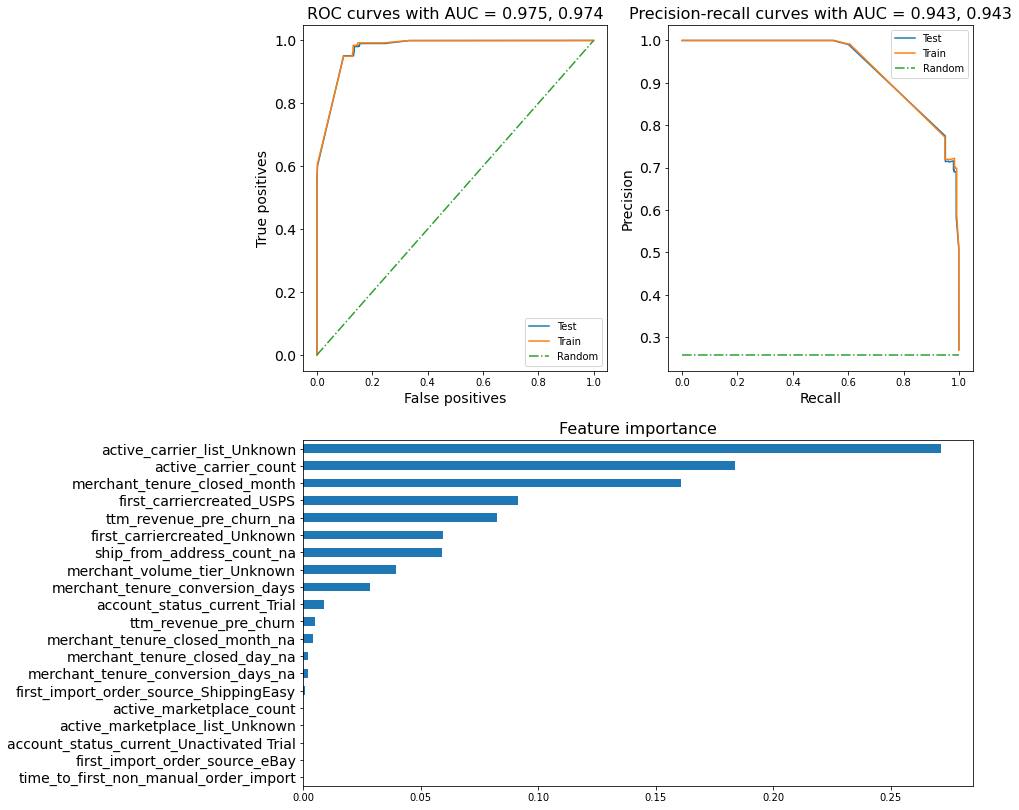

In [30]:
inputs = df_2.columns.difference([target])
forbidden_features = ['cx_merchant_id','ltv',target,
                      'tenure_end','merchant_tenure_day','merchant_tenure_month',
                      'account_status_current_Subscriber','merchant_tenure_closed_day',
                      'account_status_current_Subscriber_Cancelled',
                      'account_status_current_Subscriber Cancelled',
                      'account_status_current_Subscriber_Canceled',
                      'first_carriercreated_USPS - One Balance',
                      'last_one_twenty_day_volume'
                     ]
rfm, score_train, score_test, score_all, df_fimp = model_work_v3(df_2, inputs, target, 
                                             forbidden_features, test_frac, 
                                             scale_flag, PC_flag2, 0)

In [15]:
df_rev.head()

,cx_merchant_id,customer_id,product,revenue_date,add_on_revenue,subscription_revenue,usage_revenue,saas_revenue,committed_use_revenue,carrier_revenue,insurance_revenue,store_revenue,total_revenue,total_volume,total_carrier_spend,p_key
0,SEZ-502264,502264,ShippingEasy,2022-01-24,0.0,19.00,0.0,19.00,0.0,0.00,0.0,0.0,19.00,0,0.0,2001
1,SEZ-513724,513724,ShippingEasy,2022-06-09,0.0,29.00,0.0,29.00,0.0,0.00,0.0,0.0,29.00,0,0.0,11635
2,SEZ-493994,493994,ShippingEasy,2021-08-12,0.0,29.00,0.0,29.00,0.0,0.00,0.0,0.0,29.00,0,0.0,11653
3,SEZ-707523,707523,ShippingEasy,2021-11-13,0.0,19.00,0.0,19.00,0.0,0.00,0.0,0.0,19.00,0,0.0,11661
4,SEZ-474244,474244,ShippingEasy,2022-05-12,0.0,6.87,0.0,6.87,0.0,18.61,0.0,0.0,25.48,16,138.0,21258


In [16]:
#f = {'saas_revenue': 'sum', 'carrier_revenue': 'sum'}
#df.groupby(['month', 'UPC_ID'], as_index=False).agg(f)


df_rev_by_merchant = df_rev.groupby('cx_merchant_id').agg({
    'add_on_revenue': 'sum',
    'subscription_revenue': 'sum',
    'usage_revenue': 'sum',
    'saas_revenue': 'sum',
    'committed_use_revenue': 'sum',
    'carrier_revenue': 'sum',
    'insurance_revenue': 'sum',
    'store_revenue': 'sum',
    'total_revenue': 'sum',
    'total_volume': 'sum',
    'total_carrier_spend': 'sum'
}).reset_index()
#df_o['A_type'] = df_o.AccountId.map(df_a.set_index('Id')['Type'])

df_rev_by_merchant['survival_flag'] = df_rev_by_merchant.cx_merchant_id.map(
    df_features.set_index('cx_merchant_id')['survival_flag'])
df_features['ltv'] = df_features.cx_merchant_id.map(
    df_rev_by_merchant.set_index('cx_merchant_id')['total_revenue'])

In [17]:
df_rev_by_merchant.head()

,cx_merchant_id,add_on_revenue,subscription_revenue,usage_revenue,saas_revenue,committed_use_revenue,carrier_revenue,insurance_revenue,store_revenue,total_revenue,total_volume,total_carrier_spend,survival_flag
0,SEZ-452874,0.0,10.0,0.0,10.0,0.0,0.00,0.0,0.0,10.00,0,0.0,1
1,SEZ-452974,0.0,85.0,0.0,85.0,0.0,0.00,0.0,0.0,85.00,0,0.0,1
2,SEZ-452984,0.0,5.0,0.0,5.0,0.0,0.00,0.0,0.0,5.00,0,0.0,0
3,SEZ-452994,0.0,174.0,0.0,174.0,0.0,3.25,0.0,0.0,177.25,3,24.0,0
4,SEZ-453004,0.0,464.0,0.0,464.0,0.0,684.13,0.0,0.0,1148.13,338,4611.0,1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


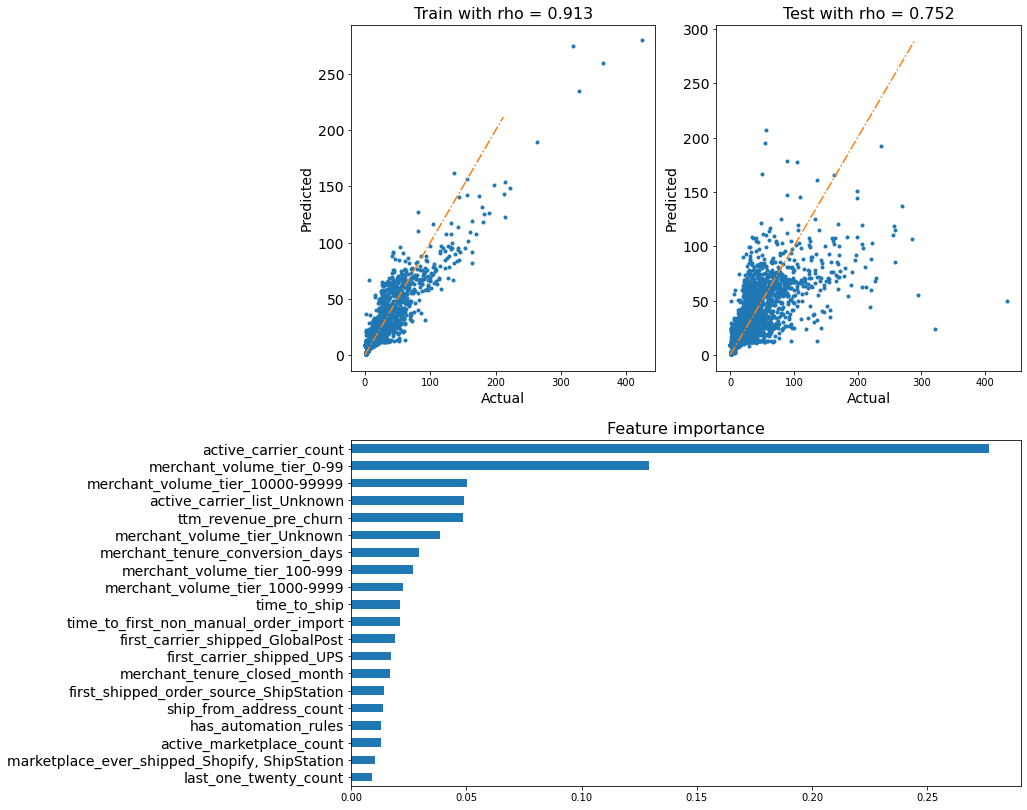

In [19]:
df_2[regress_target] = np.sqrt(df_features[regress_target])
null_ltv_index = df_2.ltv.isnull()
df_3 = df_2.loc[~null_ltv_index,:]
rfm, score_train, score_test, score_all, df_fimp = model_work_v3(
    df_3, inputs, regress_target, forbidden_features, test_frac, 
    scale_flag, PC_flag2, 1)

In [29]:
df_features['ltv'].value_counts(dropna=False)
df_features['churn_flag'] = np.nan
df_features.loc[df_features.ltv >= 0,'churn_flag'] = 0
jun2 = (df_features.ltv >= 0) & (df_features.survival_flag == 0)
df_features.loc[jun2,'churn_flag'] = 1
df_features.churn_flag.value_counts(dropna=False)

NaN    28637
0.0     6859
1.0     4902
Name: churn_flag, dtype: int64

In [32]:
df_2['churn_flag'] = df_features['churn_flag']

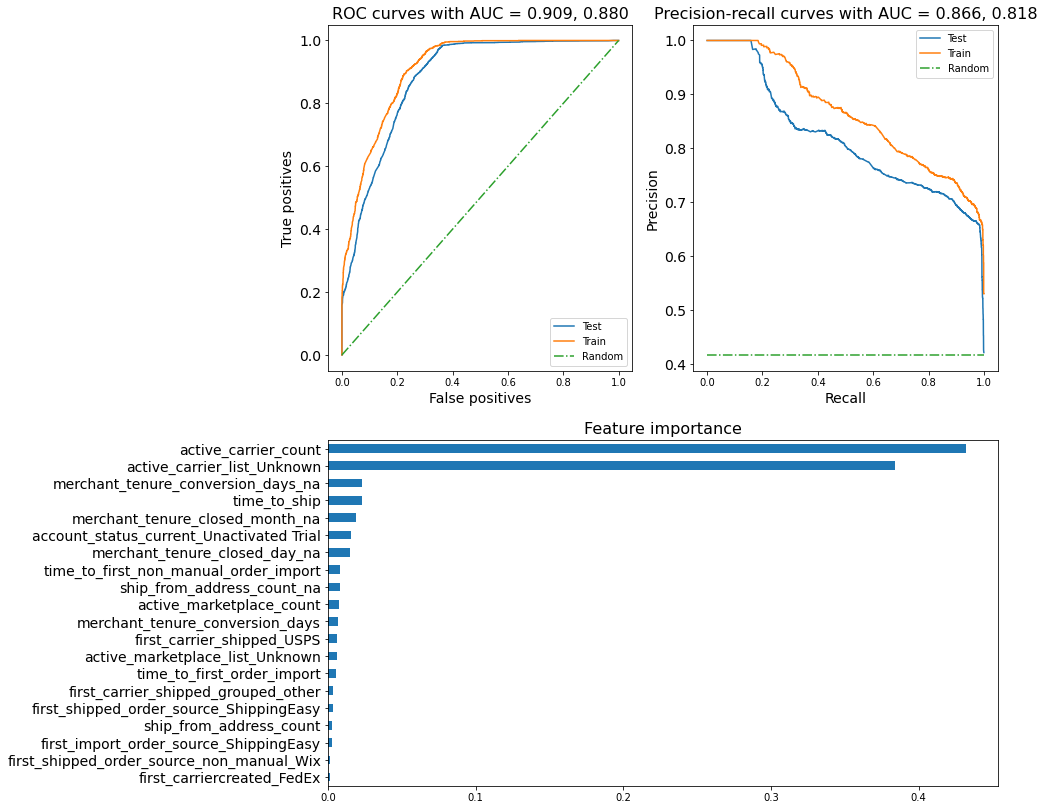

In [39]:
target3 = 'churn_flag'
null_idx = df_2[target3].isnull()
df_3 = df_2.loc[~null_idx,:]
inputs = df_3.columns.difference([target3])
forbidden_features = ['cx_merchant_id','ltv',target3,target,
                      'tenure_end','merchant_tenure_day','merchant_tenure_month',
                      'account_status_current_Subscriber','merchant_tenure_closed_day',
                      'account_status_current_Subscriber_Cancelled',
                      'account_status_current_Subscriber Cancelled',
                      'account_status_current_Subscriber_Canceled',
                      'first_carriercreated_USPS - One Balance',
                      'last_one_twenty_day_volume','ttm_revenue_pre_churn_na',
                      'merchant_tenure_closed_month','account_status_current_unactivated_trial',
                      'ttm_revenue_pre_churn','merchant_volume_tier_Unknown'
                     ]
rfm, score_train, score_test, score_all, df_fimp = model_work_v3(df_3, inputs, target3, 
                                             forbidden_features, test_frac, 
                                             scale_flag, PC_flag2, 0)

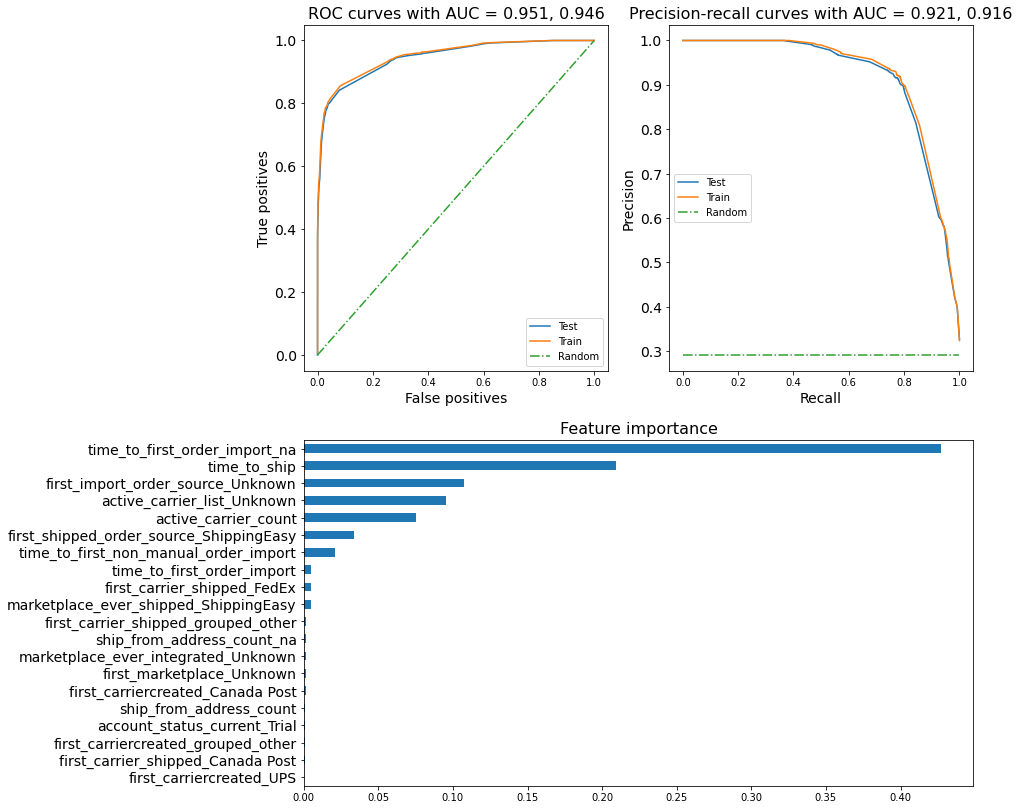

In [50]:
target4 = 'lead_conversion_flag'
df_2[target4] = df_features[target4]
df_features[target4] = 1
df_features.loc[df_features.ltv.isnull(), target4] = 0
inputs = df_2.columns.difference([target4])
forbidden_features = ['cx_merchant_id','ltv',target3,target,target4,
                      'tenure_end','merchant_tenure_day','merchant_tenure_month',
                      'account_status_current_Subscriber','merchant_tenure_closed_day',
                      'account_status_current_Subscriber_Cancelled',
                      'account_status_current_Subscriber Cancelled',
                      'account_status_current_Subscriber_Canceled',
                      'first_carriercreated_USPS - One Balance',
                      'last_one_twenty_day_volume','ttm_revenue_pre_churn_na',
                      'merchant_tenure_closed_month','account_status_current_unactivated_trial',
                      'ttm_revenue_pre_churn','merchant_volume_tier_Unknown',
                      'merchant_tenure_closed_day_na', 'merchant_tenure_closed_month_na', 
                      'merchant_tenure_conversion_days_na','time_to_ship_na',
                      'account_status_current_Unactivated Trial', 'account_status_current_Trial Unconverted',
                      'merchant_tenure_conversion_days', 'marketplace_ever_shipped_Unknown', 
                      'first_carrier_shipped_Unknown', 'first_shipped_order_source_Unknown',
                      'most_freq_shipped_from_Unknown', 'first_shipped_from_Unknown',
                      'first_shipped_from_grouped_other', 'most_freq_shipped_from_grouped_other',
                      'first_shipped_order_source_non_manual_Unknown', 'first_carrier_shipped_USPS',
                      'first_carrier_shipped_UPS'
                     ]
rfm, score_train, score_test, score_all, df_fimp = model_work_v3(df_2, inputs, target4, 
                                             forbidden_features, test_frac, 
                                             scale_flag, PC_flag2, 0)

In [20]:
print(sum(df_2.ltv.isnull()), df_2.shape) #--no conversion + 
#-- churn score (3), lead conversion (1), LTV (2)

28637 (40398, 193)


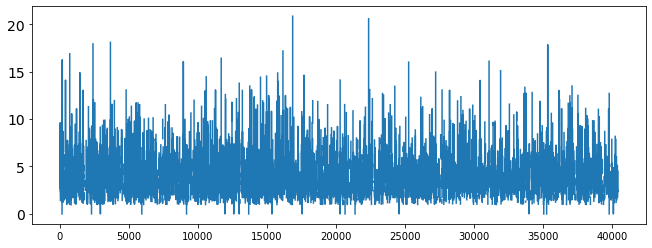

In [21]:
jun = df_2.ltv.isnull()
df_features.survival_flag[jun].mean()
plt.rcParams["figure.figsize"] = (11,4.0)
plt.plot(np.sqrt(df_2.ltv))
plt.show()

In [23]:
df_rev_by_merchant.sum()

cx_merchant_id           SEZ-452874SEZ-452974SEZ-452984SEZ-452994SEZ-45...
add_on_revenue                                                    60213.77
subscription_revenue                                            3026770.68
usage_revenue                                                      82896.6
saas_revenue                                                    3169881.05
committed_use_revenue                                                  0.0
carrier_revenue                                                 8728349.05
insurance_revenue                                                306831.35
store_revenue                                                          0.0
total_revenue                                                  12287958.05
total_volume                                                       4435685
total_carrier_spend                                            54023158.51
survival_flag                                                         6859
dtype: object

In [ ]:
plt.rcParams["figure.figsize"] = (11,4.0)
plt.hist(df_rev_by_merchant.total_revenue,1000)
plt.title('Rev by merchant distribution', fontsize=14)
plt.xlim([0,10000])
plt.show()
print('max rev = ', max(df_rev_by_merchant.total_revenue))
print('rev < 20 count =  %d out of %d' %(sum(df_rev_by_merchant.total_revenue < 20),
                                    df_rev_by_merchant.shape[0]))

In [ ]:
df_sellers.head()

In [ ]:
print(df_sellers.shape, len(set(df_sellers.cx_merchant_id)))

In [ ]:
df_shipments.head()